# Ajuste de las curvas obtenidas en el transitorio del circuito RCL Sobre amortiguado

En este tutorial analizo los datos adquiridos de un circuito **RLC transitorio sobre amortiguado**.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ L _____ C ____   
|                     |               |         |  
GND                  Vin              VC        GND
```

Parámetros:
- R = 1000 $\Omega$
- L = 10 $m H$
- C = 2 $\mu F$

- Tiempo característico $\tau = \frac{2 L}{R - \sqrt{ R^2 - 4L/C }} \approx 2$ msec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Frecuencia fuente $f \approx \frac{1}{20 \tau}$
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa) (Res. int. gen. $r_G=50 \Omega$).
- En $V_C$ se mide la tensión en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos:

In [15]:
df = pd.read_csv("datos/data_RLC_sobre.csv")

df.head()

,time,Vin,VC,I
0,1.000000e-12,5.001241,0.005131,5.785584e-07
1,1.006218e-07,4.990261,0.013048,-5.099792e-05
2,2.012426e-07,4.987353,-0.001276,-9.701468e-05
3,3.018634e-07,4.983754,0.004083,-1.486478e-04
4,4.024842e-07,5.004826,-0.007423,-1.947017e-04


Hacemos un plot exploratorio:

<Axes: xlabel='time'>

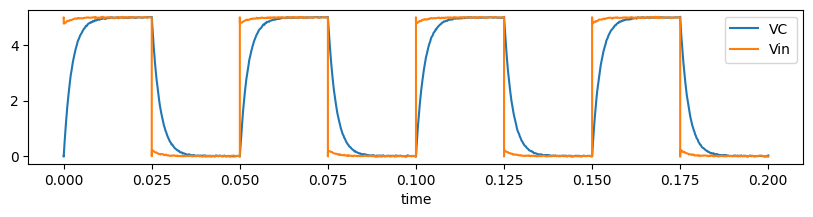

In [23]:
df.plot( x='time', y=['VC','Vin'], figsize=(10,2) )

Vamos a trabajar en mili segundos, defino la unidad temporal U,

<Axes: xlabel='t [msec]'>

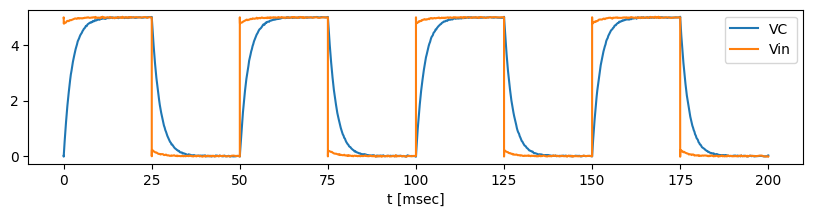

In [24]:
U = 1e-3

df["time"]/=U

df.plot( x='time', y=['VC','Vin'], figsize=(10,2), xlabel="t [msec]" )

**Filtramos** los datos para quedarnos solo con uno de transitorios. Nos quedamos con el que esta entre los tiempos 100 msec y 125 msec:

<Axes: xlabel='time'>

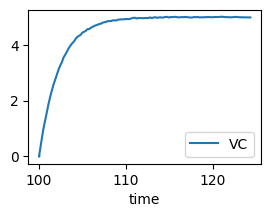

In [25]:
df_alto = df[ (df["time"]<125) & (df["time"]>100) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

El eje temporal esta trasladado, **llevamos el origen a cero** restando el primer punto, tambien pasamos nuestros datos a arrays de numpy para trabajar más cómodos el ajuste:

In [26]:
t0 = df_alto["time"].iloc[0]

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

Definimos una **ecuación** para hacer el ajuste de la tensión que cae en los bornes del capacitor:

$$
V_C = V_0 \big( 1 -  \frac{ s_2 e^{s_1 t} - s_1 e^{s_2 t} }{s_2 - s_1} \big)
$$

In [19]:
def modelo_tension(u, V0, s1, s2):                         
    z= V0*( 1.0 - ( s2*np.exp(s1*u) - s1*np.exp(s2*u) )/( s2-s1 ) )
    return z


Estimamos los valores de los parámeros para pasarselos al algoritmo como **semillas**:

In [33]:
R= 1000+50+100
L= 10e-3
C= 2e-6

g = (R/(2.0*L))*U
w02 = (1.0/(L*C))*(U**2)

s1 = -g + np.sqrt( g**2 - w02 )
s2 = -g - np.sqrt( g**2 - w02 )

print (f"s1 (Raiz lenta capacitor): {s1:.4f} 1/msec")
print (f"s2 (Raiz rápida inductor): {s2:.4f} 1/msec")

s1 (Raiz lenta capacitor): -0.4364 1/msec
s2 (Raiz rápida inductor): -114.5636 1/msec


**Ajuste**:

In [31]:
# semillas
V0_ini = 5.0
s1_ini  = -0.4
s2_ini  = -100.0

popt, pcov = curve_fit(modelo_tension, t, VC, p0=[ V0_ini, s1_ini, s2_ini ] )      

V0, s1, s2 = popt

# Errores estandar
SE_V0, SE_s1, SE_s2 = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f}) [V]")
print(f"s1 = ({s1:.4f} ± {SE_s1:.6f}) [1/msec]")
print(f"s2 = ({s2:.4f} ± {SE_s2:.6f}) [1/msec]")

Parámetros obtenidos del ajuste:
V0 = (4.9991 ± 0.0012) [V]
s1 = (-0.4361 ± 0.000681) [1/msec]
s2 = (-111.2028 ± 18.841632) [1/msec]


Hacemos un **plot** con los datos del experimento y el ajuste:

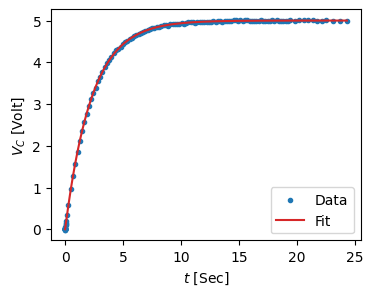

In [32]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                                    # datos

ax.plot( t, modelo_tension(t, V0, s1, s2), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_C$ [Volt]")

plt.legend(loc=4)
plt.show()